In [28]:
import os
import urllib, cStringIO

import pymongo as pm

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
from __future__ import division
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64
import json

### unadapted photo RDMs

In [29]:
## get path to fc6 features
path_to_fc6 = '/data/jefan/sketchpad_basic_fixedpose96_fc6/photos'

## get imaage ordering
ordering = pd.read_csv('/data/jefan/sketchpad_basic_fixedpose96_fc6/human_confusion_object_order.csv')
order = ordering['object_name'].values

## get paths in order that we want to make matrix
feat_files = [o +'.npy' for o in order]
path_to_feats =  [os.path.join(path_to_fc6,f) for f in feat_files]

In [30]:
## load in feats to make matrix
X = []
for path in path_to_feats:    
    x = np.load(path)
    if len(X) == 0:
        X = x
    else:
        X = np.vstack((X,x))   
## rename P for "photo" 
P = X         

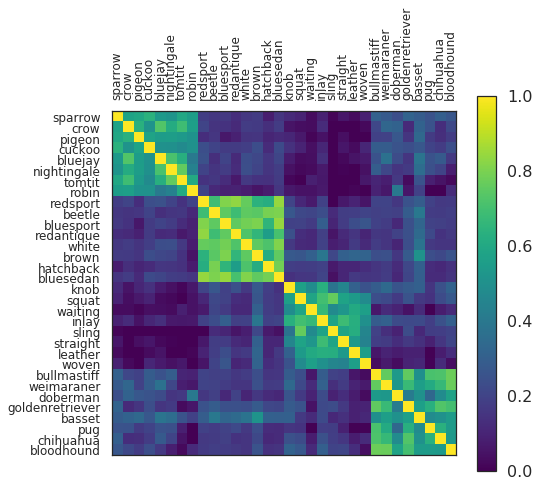

In [6]:
## plot RDM
corrmat = np.corrcoef(X)
corrmat.shape

from matplotlib import cm
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111)
cax = ax.matshow(corrmat,vmin=0,vmax=1,cmap=cm.viridis)
plt.xticks(range(len(X)), order, fontsize=12,rotation='vertical')
plt.yticks(range(len(X)), order, fontsize=12)
plt.colorbar(cax,shrink=0.8)
plt.tight_layout()

### unadapted sketch RDMs 

In [7]:
## what do the sketches look like by itself 
path_to_sketches = '/data/jefan/sketchpad_basic_fixedpose96_fc6/sketch'

In [8]:
import cPickle
db_path = '/data/jefan/sketchpad_basic_fixedpose96_fc6/'
with open(os.path.join(db_path, 'sketchpad_context_dict.pickle')) as fp:
    context_dict = cPickle.load(fp)
with open(os.path.join(db_path, 'sketchpad_label_dict.pickle')) as fp:
    label_dict = cPickle.load(fp)  

In [9]:
sketch_list = os.listdir(path_to_sketches)

In [10]:
condition = context_dict[sketch_list[0]]
label = label_dict[sketch_list[0]]

In [11]:
## load in all precomputed fc6 features as single numpy array
F = np.zeros([len(sketch_list),4096])
for i,s in enumerate(sketch_list):
    if i%1000==0:
        print '{} of {} sketches'.format(i,len(sketch_list))
    x = np.load(os.path.join(db_path,'sketch',s))
    F[i,:] = x

0 of 3072 sketches
1000 of 3072 sketches
2000 of 3072 sketches
3000 of 3072 sketches


In [12]:
# z-score normalization to de-mean & standardize variances within-voxel 
def normalize(X):
    X = X - X.mean(0)
    X = X / np.maximum(X.std(0), 1e-5)
    return X

normalize_on = False ## normalize AFTER stacking with the render features
if normalize_on:
    F = normalize(F)

In [13]:
## get lists of labels and conditions in same order as feature array above
labels = []
conditions = []
for i,s in enumerate(sketch_list):
    if i%1000==0:
        print '{} of {} sketches'.format(i,len(sketch_list))    
    labels.append(label_dict[s])
    conditions.append(context_dict[s])

## define dataframe for this feature matrix    
meta = pd.DataFrame([labels,conditions,sketch_list])
meta = meta.transpose()
meta.columns = ['label','condition','filename']

0 of 3072 sketches
1000 of 3072 sketches
2000 of 3072 sketches
3000 of 3072 sketches


In [14]:
## okay now make the class averaged feature matrices for each condition
close_feats = np.zeros([32,4096])
far_feats = np.zeros([32,4096])
for i,obj in enumerate(order):    
    inds = (meta['label']==obj) & (meta['condition']=='closer')
    close_feats[i,:] = F[inds,:].mean(0)
    inds = (meta['label']==obj) & (meta['condition']=='further')
    far_feats[i,:] = F[inds,:].mean(0)    

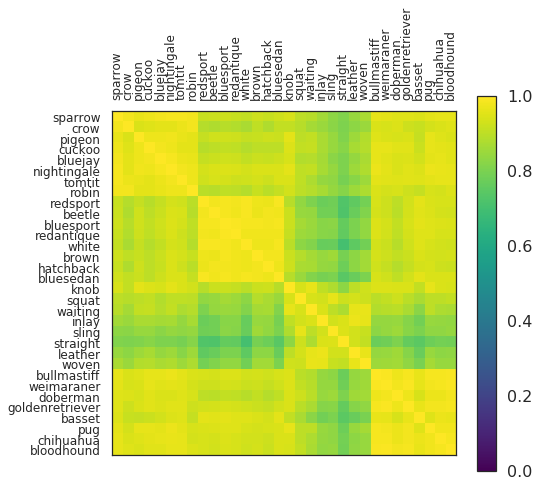

In [15]:
## plot RDM
corrmat = np.corrcoef(close_feats)
corrmat.shape
corrmat_close = corrmat

from matplotlib import cm
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111)
cax = ax.matshow(corrmat,vmin=0,vmax=1,cmap=cm.viridis)
plt.xticks(range(len(X)), order, fontsize=12,rotation='vertical')
plt.yticks(range(len(X)), order, fontsize=12)
plt.colorbar(cax,shrink=0.8)
plt.tight_layout()

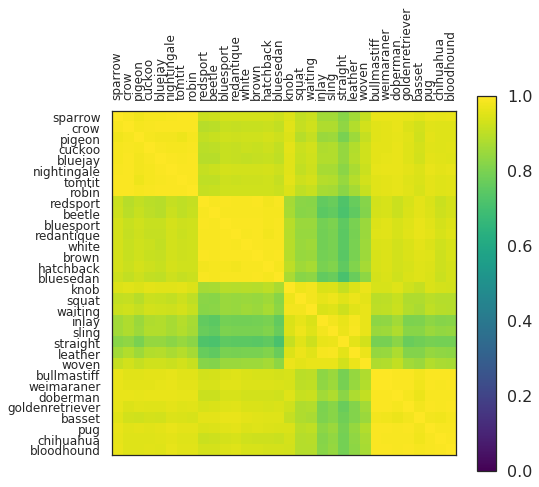

In [16]:
## plot RDM
corrmat = np.corrcoef(far_feats)
corrmat.shape
corrmat_far = corrmat

from matplotlib import cm
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111)
cax = ax.matshow(corrmat,vmin=0,vmax=1,cmap=cm.viridis)
plt.xticks(range(len(X)), order, fontsize=12,rotation='vertical')
plt.yticks(range(len(X)), order, fontsize=12)
plt.colorbar(cax,shrink=0.8)
plt.tight_layout()

### stack feature matrices on top of each other to get full feature matrix with render, close sketches, and far sketches

In [17]:
FEAT = np.vstack((P,close_feats,far_feats))

In [18]:
## normalize to mean of this dataset
normalize_on = True
if normalize_on:
    FEAT = normalize(FEAT)

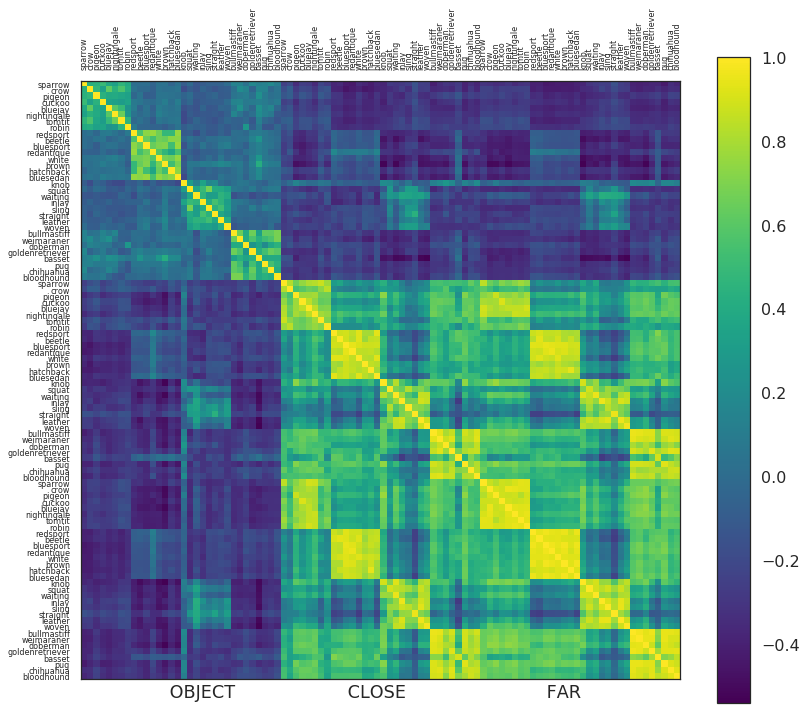

In [19]:
## plot RDM of unadapted render, close, far sketches
corrmat = np.corrcoef(FEAT)
corrmat_full = corrmat
fig = plt.figure(figsize=(12,12))
ax = plt.subplot(111)
cax = ax.matshow(corrmat,cmap=cm.viridis)
plt.xticks(range(len(X)*3), np.tile(order,3), fontsize=8,rotation='vertical')
plt.yticks(range(len(X)*3), np.tile(order,3), fontsize=8)
plt.xlabel('         OBJECT                    CLOSE                         FAR           ')
plt.colorbar(cax,shrink=0.8)    
plt.tight_layout()

In [20]:
## extract the blocks that allow us to measure sketch-render similarity
close_render = corrmat_full[:32,32:64]
far_render = corrmat_full[:32,64:]

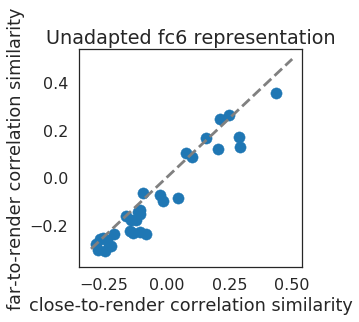

In [101]:
plt.figure(figsize=(4,4))
s = plt.scatter(np.diagonal(close_render),np.diagonal(far_render))
plt.plot([-0.3,0.5],[-0.3,0.5],linestyle='dashed',color='gray')
plt.xlabel('close-to-render correlation similarity')
plt.ylabel('far-to-render correlation similarity')
plt.title('Unadapted fc6 representation')

#### prep similarity JSONs for putting through RSA

Format for json is a dictionary of dictionaries, where each top-level key refers to one of the renders, e.g. "trial_20_cuckoo". For each render, you can look up the similarity with each sketch, referenced with an abbreviated ID taken by trimming the last 12-character string, and appending an underscore, and the trial number. E.g., 'gameID_9903-d6e6a9ff-a878-4bee-b2d5-26e2e239460a_trial_9.npy' ==> '26e2e239460a_9'

###### first, regenerate sketch and render feature matrices and normalize w/r/t mean between domains

In [188]:
## load in all precomputed fc6 features as single numpy array
F = np.zeros([len(sketch_list),4096])
for i,s in enumerate(sketch_list):
    if i%1000==0:
        print '{} of {} sketches'.format(i,len(sketch_list))
    x = np.load(os.path.join(db_path,'sketch',s))
    F[i,:] = x
    
#### sketch feature matrix    
SF = F

## get lists of labels and conditions in same order as feature array above
labels = []
conditions = []
for i,s in enumerate(sketch_list):
    if i%1000==0:
        print '{} of {} sketches'.format(i,len(sketch_list))    
    labels.append(label_dict[s])
    conditions.append(context_dict[s])

## define dataframe for this feature matrix    
meta = pd.DataFrame([labels,conditions,sketch_list])
meta = meta.transpose()
meta.columns = ['label','condition','filename']

#### sketch metadata
SM = meta

0 of 3072 sketches
1000 of 3072 sketches
2000 of 3072 sketches
3000 of 3072 sketches
0 of 3072 sketches
1000 of 3072 sketches
2000 of 3072 sketches
3000 of 3072 sketches


In [189]:
## photo feature matrix & metadata
PF = P
PM = order

In [190]:
## normalize within feature ## get mean/std from the pre class & condition-averaged version of the feature matrix 
## in other words, get the mean and sd between DOMAINs, so you have balanced number of entries in each domain
S = np.dstack((close_feats,far_feats)).mean(2)
FEAT = np.vstack((P,S))
uFEAT = FEAT.mean(0)
sdFEAT = np.maximum(FEAT.std(0), 1e-5)

normalize_on = True
if normalize_on:
    PF = (PF - uFEAT) / sdFEAT
    SF = (SF - uFEAT) / sdFEAT
    

##### now, get distance from each sketch to its target render 

###### option 1: get individual sketch-photo similarities that are computed for each sketch

In [191]:
## get distances for each sketch to every render
sp_similarity = []
for i,d in SM.iterrows():
    sketch_feat = SF[i,:]
    sp_similarity.append([np.corrcoef(SF[i,:],pf)[0,1] for pf in PF]) ## get correlation btw sketch and every object

## generate similarity dataframe    
sim = pd.DataFrame(sp_similarity)
sim.columns = order

In [192]:
## now concatenate with the main SM dataframe
SM2 = pd.concat([SM,sim],axis=1)

In [193]:
## save out to csv
SM2.to_csv('sketch_meta_item_level_similarity.csv')

###### option 2: compute sketch-photo similarities at the sketch-type (condition-object) level

In [200]:
normalize_on = True
if normalize_on:
    close_feats_norm = (close_feats - uFEAT) / sdFEAT
    far_feats_norm = (far_feats - uFEAT) / sdFEAT
    ## PF, the photo feature matrix, is already normalized
    

In [217]:
sp_centroid_similarity = []
for i,d in SM.iterrows():
    this_label = d['label']
    this_cond = d['condition']
    inds = (order==this_label)
    if this_cond=='closer':
        this_feat = close_feats_norm[inds,:]
    elif this_cond=='further':
        this_feat = far_feats_norm[inds,:]
    sp_centroid_similarity.append([np.corrcoef(this_feat,pf)[0,1] for pf in PF])

## generate similarity dataframe    
sim = pd.DataFrame(sp_centroid_similarity)
sim.columns = order
    

In [218]:
## now concatenate with the main SM dataframe
SM3 = pd.concat([SM,sim],axis=1)

In [219]:
## save out to csv
SM3.to_csv('sketch_meta_type_level_similarity.csv')

##### now get to the business of prepping jsons for real

In [220]:
# which similarity matrix are you going to use?
this_SM = SM3

In [221]:
import json

## sample json paths
json_path_prefix = '../models/refModule/json/'
json_file = 'strict-similarity-pragmatics-fixedpose-augmented-splitbycontext_conv4_2.json'
json_path = os.path.join(json_path_prefix,json_file)

def load_json(json_path):
    with open(json_path) as fp:
        data = json.load(fp)  
    return data

## build dictionary to look up the appropriate render ID to use to associate with each sketch
data = load_json(json_path)

## list of 3d rendered objects
render_list = data.keys()
    
obj_to_render = dict(zip([i.split('_')[-1] for i in data.keys()], data.keys()))  
render_to_obj = dict(zip(data.keys(),[i.split('_')[-1] for i in data.keys()]))  

In [222]:
def simplify_sketch(path): ## example path: 'gameID_9903-d6e6a9ff-a878-4bee-b2d5-26e2e239460a_trial_9.npy' ==> '26e2e239460a_9'
    path = '_'.join(os.path.splitext(os.path.basename(path))[0].split('_')[1:])
    path = path.split('-')[-1]
    path = path.replace('_trial', '')
    return path

def add_simplified_ids(X):
    ## add renderID and sketchID to dataframen
    renderID = []
    sketchID = []
    for i,d in X.iterrows():
        renderID.append(obj_to_render[d['label']])
        sketchID.append(simplify_sketch(d['filename']))
    X['renderID'] = renderID
    X['sketchID'] = sketchID    
    return X

In [223]:
this_SM = add_simplified_ids(this_SM)

In [232]:
## generate big json dictionary of dictionaries
from __future__ import division
out_json = {}
for i,this_render in enumerate(render_list):
    print i, this_render
    out_json[this_render] = {}
    for i,d in this_SM.iterrows():
        this_sketch = d['sketchID']
        _render = str(this_render.split('_')[-1])
        this_similarity = (d[_render]+1.00000001)/2 #### transform similarities to (0,1) scale!
        out_json[this_render][this_sketch] = this_similarity

0 trial_12_bluejay
1 trial_7_basset
2 trial_2_bullmastiff
3 trial_30_doberman
4 trial_10_beetle
5 trial_11_waiting
6 trial_1_bluesport
7 trial_31_bluesedan
8 trial_4_straight
9 trial_8_knob
10 trial_15_nightingale
11 trial_22_leather
12 trial_24_white
13 trial_28_chihuahua
14 trial_17_redsport
15 trial_29_sparrow
16 trial_21_woven
17 trial_25_goldenretriever
18 trial_32_squat
19 trial_3_redantique
20 trial_9_brown
21 trial_27_sling
22 trial_16_bloodhound
23 trial_23_weimaraner
24 trial_26_crow
25 trial_13_tomtit
26 trial_6_hatchback
27 trial_20_cuckoo
28 trial_18_pug
29 trial_5_inlay
30 trial_19_pigeon
31 trial_14_robin


In [233]:
## output json in the same format as the other similarity jsons
output_path = '../models/refModule/json/similarity-fc6-centroid.json'
with open(output_path, 'wb') as fp:
    json.dump(out_json, fp)

### now evaluate model predictions

In [274]:
## define set of models to compare
model_zoo = ['fc6_combined_cost','fc6_combined_nocost','fc6_S0_cost','fc6_S0_nocost']
this_model = model_zoo[0]

## define paths to model predictions
path_to_evaluate = '../models/evaluateOutput'
pred_path = os.path.join(path_to_evaluate,this_model)

In [275]:
## get file with params from this model
this_params = os.path.join('../models/bdaOutput',this_model+'_alldataParams.csv')
params = pd.read_csv(this_params)
assert np.sum(np.exp(params.posteriorProb.values))==1

In [276]:
## get list of all predictives (accepted MCMC samples)
pred_files = [i for i in os.listdir(pred_path) if i[-15:] =='Predictives.csv']

In [376]:
X = [] ## initialize giant dataframe that contains predictions from all MCMC samples

## loop through MCMC samples
for i,this_sample in enumerate(pred_files):
    
    print'{} | sample ID: {} '.format(i,int(this_sample.split('Predictives.csv')[0]))

    ## read in predictions from this sample
    sample_path = os.path.join(pred_path,this_sample)
    sample_preds = pd.read_csv(sample_path)
    sample_ind = int(this_sample.split('Predictives.csv')[0]) ## index of MCMC sample

    #### get params that generated these predictions
    #alpha = params.iloc[sample_ind]['alpha']
    #simScaling = params.iloc[sample_ind]['simScaling']
    #pragWeight = params.iloc[sample_ind]['pragWeight']
    #costWeight = params.iloc[sample_ind]['costWeight']
    posteriorProb = params.iloc[sample_ind]['posteriorProb']
    #logLikelihood = params.iloc[sample_ind]['logLikelihood']
    
    ## get congruent/incongruent context log odds for each sketch
    sketches = np.unique(sample_preds['trueSketch'].values)
    log_odds = []
    label = []
    condition = []
    for this_sketch in sketches:
        sketch_inds = sample_preds['trueSketch']==this_sketch
        these_rows = sample_preds[sketch_inds]
        cond = np.unique(these_rows['condition'].values)[0]
        other_cond = [i for i in ['closer','further'] if i != cond][0]
        obj = these_rows.iloc[0]['Target'].split('_')[-1]
        congruent_prob = these_rows[these_rows['coarseGrainedPossibleSketch']=='{}_{}'.format(cond,obj)]['modelProb'].values[0]
        other_prob = these_rows[these_rows['coarseGrainedPossibleSketch']=='{}_{}'.format(other_cond,obj)]['modelProb'].values[0]
        log_odds.append(congruent_prob - other_prob)
        label.append(obj)
        condition.append(cond)  
        
    ## make dataframe out of this sample
    sampleProb = [posteriorProb]*len(condition)
    sampleInd = [sample_ind]*len(condition)
    x = pd.DataFrame([sampleInd,sampleProb,condition,label,list(sketches),log_odds])
    x = x.transpose()
    x.columns = ['sample_ind','sample_prob','condition','label','sketch','odds']
    x = x.sort_values(by=['condition','label','sketch'])   
    
    ## concatenate dataframes containing log-odds from all MCMC samples
    if len(X)==0:
        X = x
    else:
        X = pd.concat([X,x])

In [390]:
X.odds = X.odds.astype('float')
X.sample_prob = X.sample_prob.astype('float')
X.to_csv('{}_model_predictions_log_odds.csv'.format(this_model))

In [382]:
X.head()

,sample_ind,sample_prob,condition,label,sketch,odds
29,91,-5.80914,closer,basset,08711b390cfc_9,1.23535
36,91,-5.80914,closer,basset,0934a9585321_16,1.25268
102,91,-5.80914,closer,basset,0f3dadf71345_20,1.09101
146,91,-5.80914,closer,basset,129c7cc55176_32,1.20838
153,91,-5.80914,closer,basset,16d8e4ed049d_1,1.2457


In [407]:
pp = X.groupby(['sample_ind'])['sample_prob'].mean().apply(lambda x: np.exp(x)) ## posterior probs
lo = X.groupby(['sample_ind'])['odds'].mean() ## log odds
odds_overall = np.sum(pp*lo)
print '{} log odds in favor of picking sketch from congruent-context'.format(odds_overall)

0.0481207532728 log odds overall


In [441]:
weighted_odds = []
unweighted_odds = []
for i,sketch in enumerate(sketches):
    print '{} {}'.format(i,sketch)
    Y = X[X['sketch']==sketch]
    product = Y.apply(lambda x: x['odds'] * np.exp(x['sample_prob']), axis=1)
    weighted_odds.append(np.sum(product))
    unweighted_odds.append(Y['odds'].mean())

In [452]:
weighted_odds = np.array(weighted_odds)
unweighted_odds = np.array(unweighted_odds)

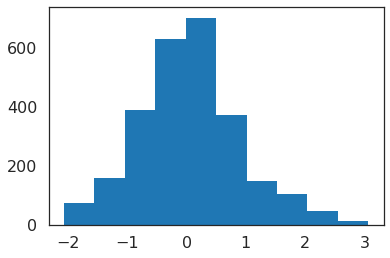

In [454]:
h = plt.hist(weighted_odds)

In [455]:
np.mean(weighted_odds)

0.04812075327276482

In [456]:
np.median(weighted_odds)

0.032125857429063605